<a href="https://colab.research.google.com/github/Htetkkhine/MMDT_2025_MLAI101/blob/htet_kay_khine/htet_kay_khine/Final%20Project/Survival_Months_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import pandas as pd
import numpy as np

df=pd.read_csv('/content/export.csv' ,index_col=0)

df = df.reset_index()            # moves Patient ID from index to a column


In [76]:

df["target"] = np.where(pd.to_numeric(df["Survival months"], errors="coerce") <= 36, 0, 1)


drop_cols = [
    "Patient ID",
    "Survival months",
    "COD to site recode",
    "SEER cause-specific death classification",
    "Vital status recode (study cutoff used)", "target"
]


X = df.drop(columns=drop_cols, errors="ignore")  # features
y = df["target"]                                 # target

print(X.columns.tolist())
print(X.shape, y.shape)



['Age recode with single ages and 85+', 'Sex', 'Race recode (White, Black, Other)', 'Marital status at diagnosis', 'Median household income inflation adj to 2023', 'Rural-Urban Continuum Code', 'Year of diagnosis', 'Primary Site - labeled', 'Histologic Type ICD-O-3', 'Grade Recode (thru 2017)', 'CS tumor size (2004-2015)', 'CS extension (2004-2015)', 'CS lymph nodes (2004-2015)', 'CS mets at dx (2004-2015)', 'Derived AJCC Stage Group, 6th ed (2004-2015)', 'RX Summ--Surg Prim Site (1998+)', 'RX Summ--Scope Reg LN Sur (2003+)', 'RX Summ--Surg Oth Reg/Dis (2003+)', 'Radiation recode', 'Chemotherapy recode (yes, no/unk)']
(1454497, 20) (1454497,)


In [77]:
X["Age recode with single ages and 85+"] = X["Age recode with single ages and 85+"].str.replace(" years","", regex=False) #remove years
X["Age recode with single ages and 85+"] = X["Age recode with single ages and 85+"].replace("85+", "85") #replace 85+ to 85
X["Age recode with single ages and 85+"] = X["Age recode with single ages and 85+"].astype(int) # convert column to integer


In [78]:

# Drop rows that have NaN in any column
X = X.dropna()
y = y[X.index]  # keep target aligned with X
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
# Check new shapes
print("X shape after dropping missing:", X.shape)
print("y shape after dropping missing:", y.shape)
print(X.isna().sum())


X shape after dropping missing: (606454, 418)
y shape after dropping missing: (606454,)
Age recode with single ages and 85+                                       0
Year of diagnosis                                                         0
Histologic Type ICD-O-3                                                   0
CS tumor size (2004-2015)                                                 0
CS extension (2004-2015)                                                  0
                                                                         ..
Radiation recode_Radioactive implants (includes brachytherapy) (1988+)    0
Radiation recode_Radioisotopes (1988+)                                    0
Radiation recode_Recommended, unknown if administered                     0
Radiation recode_Refused (1988+)                                          0
Chemotherapy recode (yes, no/unk)_Yes                                     0
Length: 418, dtype: int64


In [ ]:
# print(X.shape)
# print(X.columns)


In [79]:
X_sample = X.sample(n=50000, random_state=42)
y_sample = y.loc[X_sample.index]


In [80]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                    test_size = 0.40,
                                    random_state=42)
print(X_train.shape, X_test.shape)

(363872, 418) (242582, 418)


In [81]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#--------------------------------------------------
## ------------Logistic Regresion----------------##
#--------------------------------------------------

from sklearn.linear_model import LogisticRegression

steps = [('scaler', StandardScaler()),
         ('logReg', LogisticRegression(penalty = "l2", C =1, solver='liblinear',max_iter=500, class_weight="balanced"))]

LR_pipeline = Pipeline(steps)
LR_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logReg',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=500,
                                    solver='liblinear'))])

In [82]:
#--------------------------------------------------
## Model Evaluation ##
#--------------------------------------------------
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score


ypred_test = LR_pipeline.predict(X_test)
mat_clf = confusion_matrix(y_test, ypred_test)
report_clf = classification_report(y_test, ypred_test)

print("**Logistic Regresion**")
print(mat_clf)
print(report_clf)

ypred_testP = LR_pipeline.predict_proba(X_test)
auc = roc_auc_score(y_test, ypred_testP[:,1])
print('Accuracy:' ,auc)

**Logistic Regresion**
[[ 40025  12881]
 [ 44099 145577]]
              precision    recall  f1-score   support

           0       0.48      0.76      0.58     52906
           1       0.92      0.77      0.84    189676

    accuracy                           0.77    242582
   macro avg       0.70      0.76      0.71    242582
weighted avg       0.82      0.77      0.78    242582

Accuracy: 0.8394584754981451


In [83]:
ypred_train = LR_pipeline.predict(X_train)
mat_clf = confusion_matrix(y_train, ypred_train)
report_clf = classification_report(y_train, ypred_train)

print(mat_clf)
print(report_clf)

ypred_trainP = LR_pipeline.predict_proba(X_train)
auc = roc_auc_score(y_train, ypred_trainP[:,1])
print('Accuracy:' ,auc)

[[ 60068  18943]
 [ 66705 218156]]
              precision    recall  f1-score   support

           0       0.47      0.76      0.58     79011
           1       0.92      0.77      0.84    284861

    accuracy                           0.76    363872
   macro avg       0.70      0.76      0.71    363872
weighted avg       0.82      0.76      0.78    363872

Accuracy: 0.8408337469781741


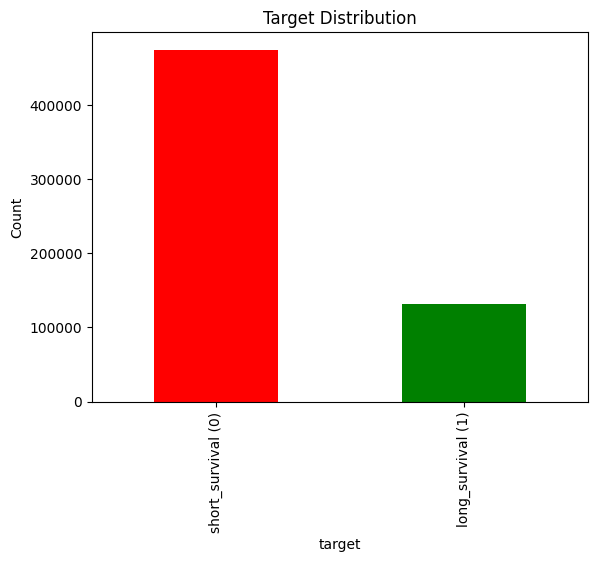

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns


y.value_counts().plot(kind="bar", color=["red","green"])
plt.xticks([0,1], ["short_survival (0)", "long_survival (1)"])
plt.title("Target Distribution")
plt.ylabel("Count")
plt.show()


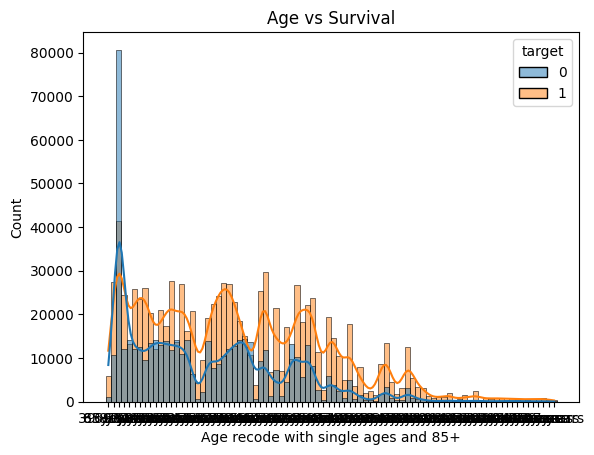

In [85]:
import seaborn as sns

sns.histplot(data=df, x="Age recode with single ages and 85+", hue="target", bins=30, kde=True)
plt.title("Age vs Survival")
plt.show()


In [86]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.4, random_state=42)

In [88]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # scale features
    ('svm', LinearSVC(C=1.0, class_weight='balanced', max_iter=5000, random_state=42))
])
svm_pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('svm',
                 LinearSVC(class_weight='balanced', max_iter=5000,
                           random_state=42))])

In [90]:
#-------------------------------
# Model Evaluation on Test Set
#-------------------------------
ypred_test = svm_pipeline.predict(X_test)
print("**Linear SVM - Test Set**")
print(confusion_matrix(y_test, ypred_test))
print(classification_report(y_test, ypred_test))

# ROC-AUC using decision function
ypred_test_scores = svm_pipeline.decision_function(X_test)
auc = roc_auc_score(y_test, ypred_test_scores)
print('ROC-AUC:', auc)

**Linear SVM - Test Set**
[[ 3309  1083]
 [ 3706 11902]]
              precision    recall  f1-score   support

           0       0.47      0.75      0.58      4392
           1       0.92      0.76      0.83     15608

    accuracy                           0.76     20000
   macro avg       0.69      0.76      0.71     20000
weighted avg       0.82      0.76      0.78     20000

ROC-AUC: 0.8354342201911307


In [91]:
#-------------------------------
# Model Evaluation on Train Set
#-------------------------------
ypred_train = svm_pipeline.predict(X_train)
print("**Linear SVM - Train Set**")
print(confusion_matrix(y_train, ypred_train))
print(classification_report(y_train, ypred_train))

ypred_train_scores = svm_pipeline.decision_function(X_train)
auc_train = roc_auc_score(y_train, ypred_train_scores)
print('Train ROC-AUC:', auc_train)

**Linear SVM - Train Set**
[[ 4970  1528]
 [ 5308 18194]]
              precision    recall  f1-score   support

           0       0.48      0.76      0.59      6498
           1       0.92      0.77      0.84     23502

    accuracy                           0.77     30000
   macro avg       0.70      0.77      0.72     30000
weighted avg       0.83      0.77      0.79     30000

Train ROC-AUC: 0.8476413433469013


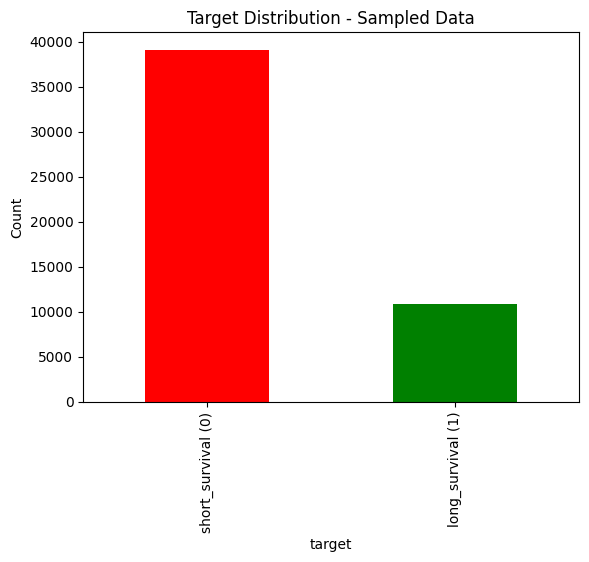

In [92]:
import matplotlib.pyplot as plt

y_sample.value_counts().plot(kind="bar", color=["red","green"])
plt.xticks([0,1], ["short_survival (0)", "long_survival (1)"])
plt.title("Target Distribution - Sampled Data")
plt.ylabel("Count")
plt.show()


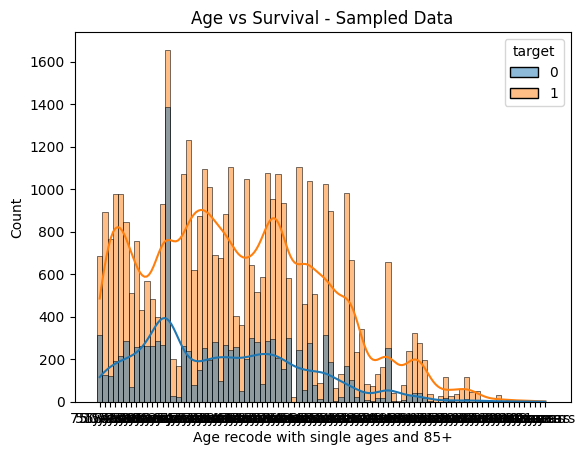

In [93]:
import seaborn as sns

sns.histplot(data=df.loc[X_sample.index],
             x="Age recode with single ages and 85+",
             hue=y_sample, bins=30, kde=True)
plt.title("Age vs Survival - Sampled Data")
plt.show()
